Graph-cut algorithm was copied from this article: https://www.geeksforgeeks.org/minimum-cut-in-a-directed-graph/

Another code (tried, but did not continue):
http://www.morethantechnical.com/2017/10/30/revisiting-graph-cut-segmentation-with-slic-and-color-histograms-wpython/

In [1]:
import pickle
import numpy as np
import imageio
import pdb

with open("../data/maps-1f.pkl", "rb") as in_f:
    maps = pickle.load(in_f)
W = np.loadtxt("../data/W-1f.csv", delimiter=',')

filename = '../data/toothpick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

# Must be the same with config in `generate_W.py`. 
frame_skip = 10
num_frames = 3

number of sp: 72
[42]
TEST
---------------
object
Lo: 5.366347918
Lb: -426.365688176
score: -0.0127466896141

background
Lo: 4.1144434723
Lb: 12.0254954139
score: 0.254923113484
---------------



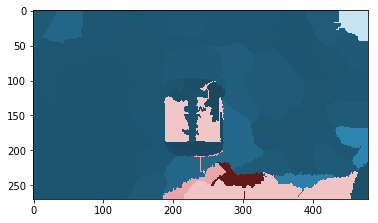

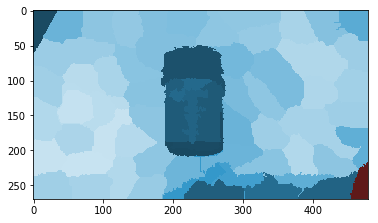

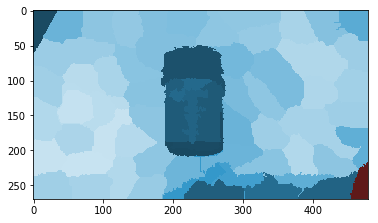

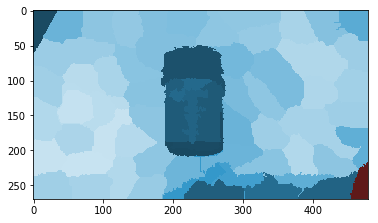

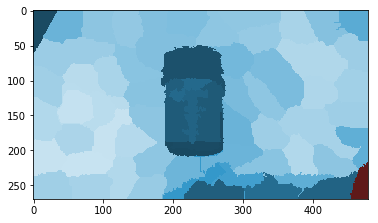

In [3]:
import sys
sys.path.append("../")
from sklearn.mixture import GaussianMixture
import maxflow
import superpixels as sp
import models as mo
from helpers import *
import math
import visualization as viz
from matplotlib import pyplot as plt

spm = sp.SuperpixelsMaps(maps)

def process_superpixel(superpixel):
    """ Process superpixel for training data
    """
    return mo.scale_colors(superpixel, new_range=(-1,1))

def calculate_score(clf_o, clf_b, superpixel):
    score_o = clf_o.score(np.array(superpixel))
    score_b = clf_b.score(np.array(superpixel))
    if (score_o + score_b) == 0:
        return 0
    else:
        return (score_o / (score_o + score_b))
#         return (score_o / score_b)
    
def create_graph(W):
    g = maxflow.Graph[float](W.shape[0], np.count_nonzero(W))
    nodes = g.add_nodes(W.shape[0])

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if W[i, j] > 0:
                g.add_edge(nodes[i], nodes[j], W[i, j], W[j, i])
    return g, nodes

def visual_hull_not_converged(vh_prev, vh_current, threshold=0):
    """ Compares previous and current visual hulls,
        and when there is no significant change, we can say
        that they are converged.
        
        vh_prev: 2D numpy array of visual hull from the previous iteration.
        vh_current: 2D numpy array of visual hull from the current iteration.
        threshold: how many minimum number of different superpixels
                   to consider the hull convergence.
    """
    if np.sum(np.abs(vh_prev - vh_current)) <= threshold:
        yield(True)

def get_msid_on_fixation_point(sp_map):
    # fixation point is assumed to be at the center of the image.
    init_obj_id = sp_map[int(sp_map.shape[0]/2.0), int(sp_map.shape[1]/2.0)]
    return init_obj_id

def highlight_superpixels_hsl_2colors(sp_map, msids, values=None, min_value=0, max_value=1.0,
                              max_intensity=220, min_intensity=60, h=(0, 100), s=150):
    """ Highlight superpixels with different hues for negative and positive values.
    """
    h_channel = np.zeros((sp_map.shape[0], sp_map.shape[1]))
    s_channel = np.zeros((sp_map.shape[0], sp_map.shape[1]))
    l_channel = np.zeros((sp_map.shape[0], sp_map.shape[1]))
    for i, sid in enumerate(msids):
        if values is None:
            value = None
        else:
            if values[i] >= 0:
                value = min_intensity + (max_intensity - min_intensity) * ((values[i])/(max_value))
            else:
                value = (min_intensity + (max_intensity - min_intensity) * ((values[i]-min_value)/(-min_value)))
#         print("value:",values[i], "color:", value)
        l_highlight = viz.highlight_superpixel(sp_map, sid, value=value, thresh=False)
        l_channel = np.sum((l_channel, l_highlight), axis=0)

        hval = h[0]
        if values[i] >= 0:
            hval = h[1]
        h_highlight = viz.highlight_superpixel(sp_map, sid, value=hval, thresh=False)
        h_channel = np.sum((h_channel, h_highlight), axis=0)

        s_highlight = viz.highlight_superpixel(sp_map, sid, value=s, thresh=False)
        s_channel = np.sum((s_channel, s_highlight), axis=0)

    hls_img = np.stack((h_channel, l_channel, s_channel), axis=2).astype(np.uint8)
    rgb_img = cv2.cvtColor(hls_img, cv2.COLOR_HLS2RGB)
    return rgb_img


clf_o = GaussianMixture(n_components=2, random_state=42)
clf_b = GaussianMixture(n_components=2, random_state=42)

g, nodes = create_graph(W)

# Learn initial color models

obj_ids = []
bg_ids = []

obj_sp = None
bg_sp = None

for map_id, sp_map in enumerate(maps):
    image = get_smaller_image(vid, map_id*frame_skip)
    center_msid = get_msid_on_fixation_point(sp_map)
    bg_msids = spm.pick_random_except([center_msid], num=10, random_state=42)
#     bg_msids = [0, 1, 2, 3, 4, 5]
    for msid in range(spm.total_sp):
        superpixel = image[sp_map == msid]
        superpixel = process_superpixel(superpixel)
        sid = spm.msid2sid(map_id, msid)
        if msid == center_msid:
            obj_ids.append(sid)
            clf_o.fit(superpixel)
            obj_sp = superpixel
        elif msid in bg_msids:
            bg_ids.append(sid)
            clf_b.fit(superpixel)
            bg_sp = superpixel

    print("number of sp:", msid+1)
print(obj_ids)

print("TEST")
print("---------------")
print("object")
print("Lo:", clf_o.score(obj_sp))
print("Lb:", clf_b.score(obj_sp))
print("score:", calculate_score(clf_o, clf_b, obj_sp))
print("")
print("background")
print("Lo:", clf_o.score(bg_sp))
print("Lb:", clf_b.score(bg_sp))
print("score:", calculate_score(clf_o, clf_b, bg_sp))
print("---------------\n")

# # visual_hull = create_visual_hull()

g, nodes = create_graph(W)

# while visual_hull_not_converged(prev_visual_hull, visual_hull):
for i in range(5):
    map_scores = [] # [[scores of map 1], [scores of map 2], etc.]
    max_scores = []
    min_scores = []
    
    for map_id, sp_map in enumerate(maps):
        # Get image in each specified frame, then calculate scores of each of
        # its superpixels. At the end of this step, all superpixels are
        # connected to either source or sink of the graph `g`.
        
        if len(map_scores) <= map_id:
            map_scores.append([])
            max_scores.append(-np.inf)
            min_scores.append(np.inf)
        image = get_smaller_image(vid, map_id*frame_skip)
        for msid in range(spm.total_sp):
            # This is where we get the superpixels
            superpixel = image[sp_map == msid]
            superpixel = process_superpixel(superpixel)
            score = calculate_score(clf_o, clf_b, superpixel)
            
            map_scores[map_id].append(score)
            if score > max_scores[map_id]:
                max_scores[map_id] = score
            if score < min_scores[map_id]:
                min_scores[map_id] = score
            
            sid = spm.msid2sid(map_id, msid)
#             if sid in obj_ids:
#                 print("sp:", sid, "score:", score, "object")
#             else:
#                 print("sp:", sid, "score:", score)
            if score >= 0:
                g.add_tedge(nodes[sid], score, 0)
            else:
                g.add_tedge(nodes[sid], 0, score)
            
    g.maxflow()

    # Reset list of object ids and fill it with
    # ids of all superpixels closer to the source, and then
    # we fit the model to object and background superpixels.
    obj_ids = []
    for i, node in enumerate(nodes):
        seg = g.get_segment(node)
#         print(i, "segment:", seg)
        map_id, msid = spm.sid2msid(i)
        image = get_smaller_image(vid, map_id*frame_skip)
        sp_map = maps[map_id]
        
        superpixel = image[sp_map == msid]
        superpixel = process_superpixel(superpixel)

        if seg == 0:
            obj_ids.append(i)
            clf_o.fit(superpixel)
        else:
            clf_b.fit(superpixel)
#     print("objects now:", obj_ids)

    # Visualize the scores (positive scores are objects)
    for map_id, sp_map in enumerate(maps):
        img = highlight_superpixels_hsl_2colors(sp_map, list(range(len(map_scores[map_id]))),
                                                values=map_scores[map_id],
                                                max_value=max_scores[map_id],
                                                min_value=min_scores[map_id]
                                               )
        plt.figure()
        plt.imshow(img)
                
            
#     for obj_id in obj_ids:
        # For each each node with the same id as the object
        # superpixel, connect it to the source node with weight
        # of 1.0. We then randomly pick one background superpixel,
        # get a node with a similar id, and then run a min-cut operation.
        # This operation will divide the nodes into 0 - closer to object
        # and 1 - closer to background.
#         pass
# # prev_visual_hull = np.zeros(sp_map.shape)        
        
        
plt.show()

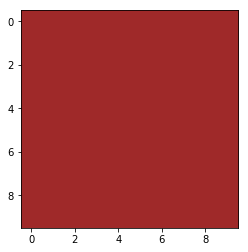

In [77]:
# Test color
h = 0
l = 100
s = 150
size = (10, 10)

hs = np.full(size, h)
ls = np.full(size, l)
ss = np.full(size, s)
hls_img = np.stack((hs, ls, ss), axis=2).astype(np.uint8)
rgb_img = cv2.cvtColor(hls_img, cv2.COLOR_HLS2RGB)

plt.imshow(rgb_img)
plt.show()

In [93]:
spm.total_sp

72